In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import math

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
class Config:
    # Origin image size
    input_size = 32
    # Input shape of image
    input_shape = [input_size, input_size, 3]
    # Learning rate of the Model
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model
    batch_size = 264
    num_classes = 10
    num_epochs = 10
    image_size = 32
    patch_size = 4
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images.astype("float32") / 255.0, test_images.astype("float32") / 255.0

# Display some information about the dataset
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

170498071/170498071 [==============================] - 4s 0us/step
Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [4]:
train = np.array(train_images).reshape((-3, Config.input_size, Config.input_size, 3))
test = np.array(test_images).reshape((-3, Config.input_size, Config.input_size, 3))

indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)

(264, 32, 32, 3)
Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


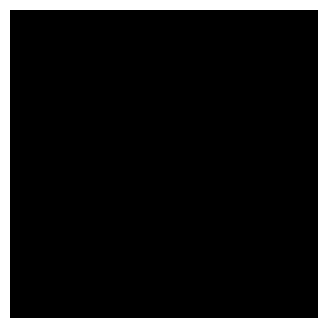

In [5]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

In [6]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

initializer = keras.initializers.RandomUniform(seed=0)

def create_products_of_givens_rotations(dim, seed):
    nb_givens_rotations = dim * int(math.ceil(math.log(float(dim))))
    q = np.eye(dim, dim)
    np.random.seed(seed)
    for _ in range(nb_givens_rotations):
        random_angle = math.pi * np.random.uniform()
        random_indices = np.random.choice(dim, 2)
        index_i = min(random_indices[0], random_indices[1])
        index_j = max(random_indices[0], random_indices[1])
        slice_i = q[index_i]
        slice_j = q[index_j]
        new_slice_i = math.cos(random_angle) * slice_i + math.sin(random_angle) * slice_j
        new_slice_j = -math.sin(random_angle) * slice_i + math.cos(random_angle) * slice_j
        q[index_i] = new_slice_i
        q[index_j] = new_slice_j
    return tf.cast(tf.constant(q), dtype=tf.float32)

def create_projection_matrix(m, d, seed=0, scaling=0, struct_mode=False):
    nb_full_blocks = int(m / d)
    block_list = []
    current_seed = seed
    for _ in range(nb_full_blocks):
        if struct_mode:
            q = create_products_of_givens_rotations(d, seed)
        else:
            unstructured_block = tf.random.normal((d, d), seed=current_seed)
            q, _ = tf.linalg.qr(unstructured_block)
            q = tf.transpose(q)
        block_list.append(q)
        current_seed += 1
    remaining_rows = m - nb_full_blocks * d
    if remaining_rows > 0:
        if struct_mode:
            q = create_products_of_givens_rotations(d, seed)
        else:
            unstructured_block = tf.random.normal((d, d), seed=current_seed)
            q, _ = tf.linalg.qr(unstructured_block)
            q = tf.transpose(q)
        block_list.append(q[0:remaining_rows])
    final_matrix = tf.experimental.numpy.vstack(block_list)
    current_seed += 1

    if scaling == 0:
        multiplier = tf.norm(tf.random.normal((m, d), seed=current_seed), axis=1)
    elif scaling == 1:
        multiplier = tf.math.sqrt(float(d)) * tf.ones((m))
    else:
        raise ValueError("Scaling must be one of {0, 1}. Was %s" % scaling)

    return tf.linalg.matmul(tf.linalg.diag(multiplier), final_matrix)

# Example usage
m = 64  # Number of random projections
d = 264 # Dimensionality of each random projection
projection_matrix = create_projection_matrix(m, d)
projection_matrix.shape  # Check the shape of the created projection matrix

projection_matrix

<tf.Tensor: shape=(64, 264), dtype=float32, numpy=
array([[-0.38686532, -0.6442673 ,  0.00981632, ...,  1.0151552 ,
        -0.48501194,  2.526372  ],
       [ 2.554467  , -0.78443664,  1.4459679 , ..., -1.5253346 ,
         1.7976891 , -0.7592521 ],
       [-0.21831064,  1.0077544 , -0.695573  , ...,  1.0947789 ,
        -0.00459066,  0.17657514],
       ...,
       [ 1.6360229 , -0.92126226,  0.22026485, ...,  0.7007591 ,
        -1.0823609 , -0.7187941 ],
       [ 0.23786639,  0.5421667 ,  0.47651663, ...,  0.70916355,
         0.23669659, -0.8986989 ],
       [ 2.2788465 ,  0.9752117 , -0.23861828, ...,  1.236025  ,
        -0.20824668, -1.1533142 ]], dtype=float32)>

In [7]:
def softmax_kernel_transformation(data,
                                  is_query,
                                  projection_matrix= projection_matrix,
                                  numerical_stabilizer=0.000001):
  data_normalizer = 1.0 / (
      tf.math.sqrt(tf.math.sqrt(tf.dtypes.cast(data.shape[-1], tf.float32))))
  data = data_normalizer * data
  ratio = 1.0 / tf.math.sqrt(
      tf.dtypes.cast(projection_matrix.shape[0], tf.float32))
  data_dash = tf.einsum("blhd,md->blhm", data, projection_matrix)
  diag_data = tf.math.square(data)
  diag_data = tf.math.reduce_sum(
      diag_data, axis=tf.keras.backend.ndim(data) - 1)
  diag_data = diag_data / 2.0
  diag_data = tf.expand_dims(diag_data, axis=tf.keras.backend.ndim(data) - 1)
  last_dims_t = (len(data_dash.shape) - 1,)
  attention_dims_t = (len(data_dash.shape) - 3,)
  if is_query:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t, keepdims=True)) + numerical_stabilizer)
  else:
    data_dash = ratio * (
        tf.math.exp(data_dash - diag_data - tf.math.reduce_max(
            data_dash, axis=last_dims_t + attention_dims_t, keepdims=True)) +
        numerical_stabilizer)

  return data_dash

In [8]:
def __init__(self,
               hidden_size,
               num_heads,
               attention_dropout,
               kernel_transformation=softmax_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               projection_matrix_type= projection_matrix,
               nb_random_features=0):
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.attention_dropout = attention_dropout
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

In [9]:
class Attention(tf.keras.layers.Layer):
  def __init__(self,
               hidden_size,
               num_heads,
               attention_dropout,
               kernel_transformation=softmax_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               projection_matrix_type= projection_matrix,
               nb_random_features=0):
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.attention_dropout = attention_dropout
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

  def build(self, input_shape):
    # Layers for linearly projecting the queries, keys, and values.
    size_per_head = self.hidden_size // self.num_heads

    def _glorot_initializer(fan_in, fan_out):
      limit = math.sqrt(6.0 / (fan_in + fan_out))
      return tf.keras.initializers.RandomUniform(minval=-limit, maxval=limit)

    attention_initializer = _glorot_initializer(input_shape.as_list()[-1],
                                                self.hidden_size)
    self.query_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="query")
    self.key_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="key")
    self.value_dense_layer = DenseEinsum(
        output_shape=(self.num_heads, size_per_head),
        kernel_initializer=attention_initializer,
        use_bias=False,
        name="value")

    output_initializer = _glorot_initializer(self.hidden_size, self.hidden_size)
    self.output_dense_layer = DenseEinsum(
        output_shape=self.hidden_size,
        num_summed_dimensions=2,
        kernel_initializer=output_initializer,
        use_bias=False,
        name="output_transform")
    super(Attention, self).build(input_shape)

  def get_config(self):
    return {
        "hidden_size": self.hidden_size,
        "num_heads": self.num_heads,
        "attention_dropout": self.attention_dropout,
    }

  def call(self,
           query_input,
           source_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):

    # Linearly project the query, key and value using different learned
    # projections. Splitting heads is automatically done during the linear
    # projections --> [batch_size, length, num_heads, dim_per_head].
    query = self.query_dense_layer(query_input)
    key = self.key_dense_layer(source_input)
    value = self.value_dense_layer(source_input)

    if self.projection_matrix_type is None:
      projection_matrix = None
    else:
      dim = query.shape[-1]
      seed = tf.math.ceil(tf.math.abs(tf.math.reduce_sum(query) * BIG_CONSTANT))
      seed = tf.dtypes.cast(seed, tf.int32)
      projection_matrix = create_projection_matrix(
          self.nb_random_features, dim, seed=seed)

    if cache is not None:
      # Combine cached keys and values with new keys and values.
      if decode_loop_step is not None:
        cache_k_shape = cache["k"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_k_shape[1], dtype=key.dtype),
            [1, cache_k_shape[1], 1, 1])
        key = cache["k"] + key * indices
        cache_v_shape = cache["v"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_v_shape[1], dtype=value.dtype),
            [1, cache_v_shape[1], 1, 1])
        value = cache["v"] + value * indices
      else:
        key = tf.concat([tf.cast(cache["k"], key.dtype), key], axis=1)
        value = tf.concat([tf.cast(cache["v"], value.dtype), value], axis=1)

      # Update cache
      cache["k"] = key
      cache["v"] = value

    attention_output = favor_attention(query, key, value,
                                       self.kernel_transformation, self.causal,
                                       projection_matrix)
    attention_output = self.output_dense_layer(attention_output)
    return attention_output

In [10]:
def favor_attention(query,
                    key,
                    value,
                    kernel_transformation,
                    causal,
                    projection_matrix= projection_matrix):
  query_prime = kernel_transformation(query, True,
                                      projection_matrix)  # [B,L,H,M]
  key_prime = kernel_transformation(key, False, projection_matrix)  # [B,L,H,M]
  query_prime = tf.transpose(query_prime, [1, 0, 2, 3])  # [L,B,H,M]
  key_prime = tf.transpose(key_prime, [1, 0, 2, 3])  # [L,B,H,M]
  value = tf.transpose(value, [1, 0, 2, 3])  # [L,B,H,D]

  if causal:
    av_attention = causal_numerator(query_prime, key_prime, value)
    attention_normalizer = causal_denominator(query_prime, key_prime)
  else:
    av_attention = noncausal_numerator(query_prime, key_prime, value)
    attention_normalizer = noncausal_denominator(query_prime, key_prime)
  # TODO(kchoro): Add more comments.
  av_attention = tf.transpose(av_attention, [1, 0, 2, 3])
  attention_normalizer = tf.transpose(attention_normalizer, [1, 0, 2])
  attention_normalizer = tf.expand_dims(attention_normalizer,
                                        len(attention_normalizer.shape))
  return av_attention / attention_normalizer

In [11]:
class Attention(tf.keras.layers.Layer):
  def __init__(self,
               hidden_size,
               num_heads,
               attention_dropout,
               kernel_transformation=softmax_kernel_transformation,
               numerical_stabilizer=0.001,
               causal=False,
               projection_matrix_type=None,
               nb_random_features=0):
    if hidden_size % num_heads:
      raise ValueError(
          "Hidden size ({}) must be divisible by the number of heads ({})."
          .format(hidden_size, num_heads))

    super(Attention, self).__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads
    self.attention_dropout = attention_dropout
    self.kernel_transformation = kernel_transformation
    self.numerical_stabilizer = numerical_stabilizer
    self.causal = causal
    self.projection_matrix_type = projection_matrix_type
    self.nb_random_features = nb_random_features

In [12]:
import tensorflow as tf

_CHR_IDX = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"]

@tf.keras.utils.register_keras_serializable(package="Text")
class DenseEinsum(tf.keras.layers.Layer):
  def __init__(self,
               output_shape,
               num_summed_dimensions=1,
               activation=None,
               use_bias=True,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(DenseEinsum, self).__init__(**kwargs)
    self._output_shape = output_shape if isinstance(
        output_shape, (list, tuple)) else (output_shape,)
    self._activation = tf.keras.activations.get(activation)
    self._use_bias = use_bias
    self._kernel_initializer = tf.keras.initializers.get(kernel_initializer)
    self._bias_initializer = tf.keras.initializers.get(bias_initializer)
    self._kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
    self._bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
    self._kernel_constraint = tf.keras.constraints.get(kernel_constraint)
    self._bias_constraint = tf.keras.constraints.get(bias_constraint)
    self._num_summed_dimensions = num_summed_dimensions
    self._einsum_string = None

  def _build_einsum_string(self, free_input_dims, bound_dims, output_dims):
    input_str = ""
    kernel_str = ""
    output_str = ""
    letter_offset = 0
    for i in range(free_input_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      output_str += char

    letter_offset += free_input_dims
    for i in range(bound_dims):
      char = _CHR_IDX[i + letter_offset]
      input_str += char
      kernel_str += char

    letter_offset += bound_dims
    for i in range(output_dims):
      char = _CHR_IDX[i + letter_offset]
      kernel_str += char
      output_str += char

    return input_str + "," + kernel_str + "->" + output_str

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    input_rank = input_shape.rank
    free_input_dims = input_rank - self._num_summed_dimensions
    output_dims = len(self._output_shape)

    self._einsum_string = self._build_einsum_string(free_input_dims,
                                                    self._num_summed_dimensions,
                                                    output_dims)

    # This is only saved for testing purposes.
    self._kernel_shape = (
        input_shape[free_input_dims:].concatenate(self._output_shape))

    self._kernel = self.add_weight(
        "kernel",
        shape=self._kernel_shape,
        initializer=self._kernel_initializer,
        regularizer=self._kernel_regularizer,
        constraint=self._kernel_constraint,
        dtype=self.dtype,
        trainable=True)
    if self._use_bias:
      self._bias = self.add_weight(
          "bias",
          shape=self._output_shape,
          initializer=self._bias_initializer,
          regularizer=self._bias_regularizer,
          constraint=self._bias_constraint,
          dtype=self.dtype,
          trainable=True)
    else:
      self._bias = None
    super(DenseEinsum, self).build(input_shape)

  def get_config(self):
    config = {
        "output_shape":
            self._output_shape,
        "num_summed_dimensions":
            self._num_summed_dimensions,
        "activation":
            tf.keras.activations.serialize(self._activation),
        "use_bias":
            self._use_bias,
        "kernel_initializer":
            tf.keras.initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            tf.keras.initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            tf.keras.regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            tf.keras.regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            tf.keras.regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            tf.keras.constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            tf.keras.constraints.serialize(self._bias_constraint)
    }
    base_config = super(DenseEinsum, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def call(self, inputs):
    ret = tf.einsum(self._einsum_string, inputs, self._kernel)
    if self._use_bias:
      ret += self._bias
    if self._activation is not None:
      ret = self._activation(ret)
    return ret

In [13]:
def call(self,
           query_input,
           source_input,
           bias,
           training,
           cache=None,
           decode_loop_step=None):

    # Linearly project the query, key and value using different learned
    # projections. Splitting heads is automatically done during the linear
    # projections --> [batch_size, length, num_heads, dim_per_head].
    query = self.query_dense_layer(query_input)
    key = self.key_dense_layer(source_input)
    value = self.value_dense_layer(source_input)

    if self.projection_matrix_type is None:
      projection_matrix = None
    else:
      dim = query.shape[-1]
      seed = tf.math.ceil(tf.math.abs(tf.math.reduce_sum(query) * BIG_CONSTANT))
      seed = tf.dtypes.cast(seed, tf.int32)
      projection_matrix = create_projection_matrix(
          self.nb_random_features, dim, seed=seed)

    if cache is not None:
      # Combine cached keys and values with new keys and values.
      if decode_loop_step is not None:
        cache_k_shape = cache["k"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_k_shape[1], dtype=key.dtype),
            [1, cache_k_shape[1], 1, 1])
        key = cache["k"] + key * indices
        cache_v_shape = cache["v"].shape.as_list()
        indices = tf.reshape(
            tf.one_hot(decode_loop_step, cache_v_shape[1], dtype=value.dtype),
            [1, cache_v_shape[1], 1, 1])
        value = cache["v"] + value * indices
      else:
        key = tf.concat([tf.cast(cache["k"], key.dtype), key], axis=1)
        value = tf.concat([tf.cast(cache["v"], value.dtype), value], axis=1)

      # Update cache
      cache["k"] = key
      cache["v"] = value

    attention_output = favor_attention(query, key, value,
                                       self.kernel_transformation, self.causal,
                                       projection_matrix)
    attention_output = self.output_dense_layer(attention_output)
    return attention_output

In [14]:
def noncausal_numerator(qs, ks, vs):
  kvs = tf.einsum("lbhm,lbhd->bhmd", ks, vs)
  return tf.einsum("lbhm,bhmd->lbhd", qs, kvs)

def noncausal_denominator(qs, ks):
  all_ones = tf.ones([ks.shape[0]])
  ks_sum = tf.einsum("lbhm,l->bhm", ks, all_ones)
  return tf.einsum("lbhm,bhm->lbh", qs, ks_sum)

In [15]:
class MHFA(Attention):

  def call(
      self,
      query,
      value,
      key=None,
      attention_mask= None,
      return_attention_scores = None,
      training= None,
      use_causal_mask= False,
  ):

    if key is None:
      key= value

    attention_output=  super(MHFA, self).call(query, key, None, training)
    return attention_output

In [16]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = MHFA(kernel_transformation=softmax_kernel_transformation, nb_random_features=64,  hidden_size=64, attention_dropout=0.1, num_heads=8)(x1,x1)

        #Layer Normalization 2
        x4 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)

        # Skip Connnection 1
        x2 = attention_output + encoder_patches

        # Layer Normalization 3
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

        # Skip Connnection 2
        encoder_patches = x3 + x2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            7         ['input_1[0][0]']             
                                                                                                  
 patches (Patches)           (None, None, 48)             0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 64, 64)               7232      ['patches[0][0]']             
 r)                                                                                           

In [18]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [19]:
history = vit_classifier.fit(train, train_labels, epochs=60, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/60
190/190 [==============================] - 29s 81ms/step - loss: 2.1477 - accuracy: 0.2562 - val_loss: 1.6450 - val_accuracy: 0.4005
Epoch 2/60
190/190 [==============================] - 14s 73ms/step - loss: 1.6573 - accuracy: 0.3931 - val_loss: 1.4379 - val_accuracy: 0.4864
Epoch 3/60
190/190 [==============================] - 14s 74ms/step - loss: 1.5263 - accuracy: 0.4496 - val_loss: 1.3579 - val_accuracy: 0.5216
Epoch 4/60
190/190 [==============================] - 14s 73ms/step - loss: 1.4444 - accuracy: 0.4813 - val_loss: 1.2795 - val_accuracy: 0.5468
Epoch 5/60
190/190 [==============================] - 16s 82ms/step - loss: 1.3898 - accuracy: 0.5001 - val_loss: 1.2379 - val_accuracy: 0.5734
Epoch 6/60
190/190 [==============================] - 14s 73ms/step - loss: 1.3378 - accuracy: 0.5214 - val_loss: 1.1768 - val_accuracy: 0.5814
Epoch 7/60
190/190 [==============================] - 14s 73ms/step - loss: 1.2884 - accuracy: 0.5389 - val_loss: 1.1250 - val_accuracy:

In [20]:
def plot_history(history, filename, model_name):
  best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
  fig, ax1 = plt.subplots(figsize=(18,8))
  plt.title(' '.join([model_name, 'Maximum Accuracy is %1.4f' % max(history.history['val_accuracy'])]))
  ax1.set_xlabel('Epochs')
  ax1.set_xticks(range(1,61))
  ax1.set_ylabel('Loss')
  ax1.plot(range(1,61), history.history['loss'], 'r', label='Train Loss')
  ax1.plot(range(1,61), history.history['val_loss'], 'orange', label='Test Loss')
  ax1.axvline(best_epoch, color='m', lw=4, alpha=0.5, label='Best epoch')
  ax1.legend()

  ax2 = ax1.twinx()
  ax2.set_ylabel('Accuracy')
  ax2.plot(range(1,61), history.history['accuracy'], 'g', label='Train Accuracy')
  ax2.plot(range(1,61), history.history['val_accuracy'], 'b', label='Test Accuracy')
  ax2.legend()

  plt.savefig(filename)
  plt.show()

#plotting learning curves and labelling them
filename='Model.png'
model_name = 'Model'
plot_history(history, filename, model_name)

print("Maximum Test Accuracy: ", max(history.history['val_accuracy']))
print("Maximum Train Accuracy: ", max(history.history['accuracy']))

Maximum Test Accuracy:  0.7699999809265137
Maximum Train Accuracy:  0.847100019454956
